In [1]:
import os, codecs, json, time
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
INPUT_TRAIN_FILE='data\\train.csv'
INPUT_TEST_FILE='data\\test.csv'
FLATTEN_FLAG = False

## 1 Washing Data
Read a small subset of data to have a glance of what the data look like.

In [4]:
st = time.time()
train_df = pd.read_csv(INPUT_TRAIN_FILE, nrows=1000)
print ("Reading", time.time()-st)
print (len(train_df))

Reading 0.06001400947570801
1000


In [5]:
train_df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


According to the table, I find some columns are in JSON format.

In [6]:
train_df.device[0]

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [7]:
train_df.geoNetwork[0]

'{"continent": "Asia", "subContinent": "Western Asia", "country": "Turkey", "region": "Izmir", "metro": "(not set)", "city": "Izmir", "cityId": "not available in demo dataset", "networkDomain": "ttnet.com.tr", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [8]:
train_df.totals[0]

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1"}'

In [9]:
train_df.trafficSource[0]

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In [10]:
train_df.describe()

,date,fullVisitorId,visitId,visitNumber,visitStartTime
count,1000.0,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03
mean,20160902.0,4.545762e+18,1.472841e+09,2.035000,1.472841e+09
std,0.0,3.053412e+18,2.240422e+04,6.515384,2.240424e+04
min,20160902.0,2.953262e+15,1.472800e+09,1.000000,1.472800e+09
25%,20160902.0,1.647353e+18,1.472824e+09,1.000000,1.472824e+09
50%,20160902.0,4.418539e+18,1.472840e+09,1.000000,1.472840e+09
75%,20160902.0,7.256540e+18,1.472858e+09,1.000000,1.472858e+09
max,20160902.0,9.991882e+18,1.472886e+09,136.000000,1.472886e+09


As a result, we have to deal with fields written in JSON format. The `flatten` method is adopted from https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook. I modified it to direct export both train and test data to the csv file.

In [11]:
from pandas.io.json import json_normalize
json_fields = ['device', 'geoNetwork', 'totals', 'trafficSource']
def flatten(flag=False):
    if not flag:
        return   
    df = pd.read_csv(INPUT_TRAIN_FILE, 
                     converters={column: json.loads for column in json_fields}, 
                     dtype={'fullVisitorId': 'str'})
    
    for col in json_fields:
        col_as_df = json_normalize(df[col])
        col_as_df.columns = [f"{col}.{subcol}" for subcol in col_as_df.columns]
        df = df.drop(col, axis=1).merge(col_as_df, right_index=True, left_index=True)
    df.to_csv('data\\f_train.csv')
    del df
    df = pd.read_csv(INPUT_TEST_FILE, 
                     converters={column: json.loads for column in json_fields}, 
                     dtype={'fullVisitorId': 'str'})
    
    for col in json_fields:
        col_as_df = json_normalize(df[col])
        col_as_df.columns = [f"{col}.{subcol}" for subcol in col_as_df.columns]
        df = df.drop(col, axis=1).merge(col_as_df, right_index=True, left_index=True)
    df.to_csv('data\\f_test.csv')
flatten(FLATTEN_FLAG)
train_df_f = pd.read_csv('data\\f_train.csv', 
                     dtype={'fullVisitorId': 'str'})

In [12]:
train_df_f.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


Browse the flattened file in Microsoft Excel, I see the values of colmns, especially for those text data. I decided to write lines of codes to automatically identicate how many categories they have. Text data can be view into two groups: plain string data like ID# and category data. Some colomns contains integer value can also be regarded as category data.

Real number data:
 - visitNumber
 - totals.hits
 - totals.pageviews
 - totals.transactionRevenue

Datetime data:
 - date
 - visitStartTime (TimeStamp)

Plain string data:
 - fullVisitorId
 - visitId
 - sessionId
 
Category data:
 - channelGrouping
 - socialEngagementType
 - device.browser
 - device.browserSize
 - device.browserVersion
 - device.deviceCategory
 - device.flashVersion
 - device.isMobile
 - device.language
 - device.mobileDeviceBranding
 - device.mobileDeviceInfo
 - device.mobileDeviceMarketingName
 - device.mobileDeviceModel
 - device.mobileInputSelector
 - device.operatingSystem
 - device.operatingSystemVersion
 - device.screenColors
 - device.screenResolution
 - geoNetwork.city
 - geoNetwork.cityId
 - geoNetwork.continent
 - geoNetwork.country
 - geoNetwork.latitude
 - geoNetwork.longitude
 - geoNetwork.metro
 - geoNetwork.networkDomain
 - geoNetwork.networkLocation
 - geoNetwork.region
 - geoNetwork.subContinent
 - totals.bounces
 - totals.newVisits
 - totals.transactionRevenue
 - totals.visits
 - trafficSource.adContent
 - trafficSource.adwordsClickInfo.adNetworkType
 - trafficSource.adwordsClickInfo.criteriaParameters
 - trafficSource.adwordsClickInfo.gclId
 - trafficSource.adwordsClickInfo.isVideoAd
 - trafficSource.adwordsClickInfo.page
 - trafficSource.adwordsClickInfo.slot
 - trafficSource.campaign
 - trafficSource.campaignCode
 - trafficSource.isTrueDirect
 - trafficSource.keyword
 - trafficSource.medium
 - trafficSource.referralPath
 - trafficSource.source

In [13]:
CATEGORY_COLUMN_NAMES = [
    'channelGrouping',
    'socialEngagementType',
    'device.browser',
    'device.browserSize',
    'device.browserVersion',
    'device.deviceCategory',
    'device.flashVersion',
    'device.isMobile',
    'device.language',
    'device.mobileDeviceBranding',
    'device.mobileDeviceInfo',
    'device.mobileDeviceMarketingName',
    'device.mobileDeviceModel',
    'device.mobileInputSelector',
    'device.operatingSystem',
    'device.operatingSystemVersion',
    'device.screenColors',
    'device.screenResolution',
    'geoNetwork.city',
    'geoNetwork.cityId',
    'geoNetwork.continent',
    'geoNetwork.country',
    'geoNetwork.latitude',
    'geoNetwork.longitude',
    'geoNetwork.metro',
    'geoNetwork.networkDomain',
    'geoNetwork.networkLocation',
    'geoNetwork.region',
    'geoNetwork.subContinent',
    'totals.bounces',
    'totals.newVisits',
    'totals.transactionRevenue',
    'totals.visits',
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.criteriaParameters',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaign',
    'trafficSource.campaignCode',
    'trafficSource.isTrueDirect',
    'trafficSource.keyword',
    'trafficSource.medium',
    'trafficSource.referralPath',
    'trafficSource.source',
]

Check values and their counts in each column.

In [14]:
for col in CATEGORY_COLUMN_NAMES:
    print (train_df_f[col].value_counts())

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64
Not Socially Engaged    903653
Name: socialEngagementType, dtype: int64
Chrome                                         620364
Safari                                         182245
Firefox                                         37069
Internet Explorer                               19375
Edge                                            10205
Android Webview                                  7865
Safari (in-app)                                  6850
Opera Mini                                       6139
Opera                                            5643
UC Browser                                       2427
YaBrowser                                        2096
Coc Coc                                           727
Amazon Silk                                 

(not set)                244881
unknown.unknown          146034
comcast.net               28743
rr.com                    14827
verizon.net               13637
ttnet.com.tr              13228
comcastbusiness.net        9985
hinet.net                  7919
virginm.net                6414
3bb.co.th                  6046
prod-infinitum.com.mx      5960
cox.net                    5812
sbcglobal.net              5388
btcentralplus.com          5304
att.net                    5230
google.com                 5035
optonline.net              4972
totbb.net                  4895
vnpt.vn                    4508
asianet.co.th              4374
pldt.net                   4008
rima-tde.net               3963
amazonaws.com              3769
t-ipconnect.de             3656
telecomitalia.it           3571
qwest.net                  3534
airtelbroadband.in         3389
virtua.com.br              3318
bell.ca                    2904
ztomy.com                  2845
                          ...  
standard

Name: trafficSource.adwordsClickInfo.criteriaParameters, dtype: int64
Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ      70
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ      41
CJH1vbf94M8CFUElgQodyakHgQ                                                                      29
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ      27
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBEJui6ggr6ocA-eDC2-lX7W1m5IA1c_qNbzwZVTqUanxoCb5rw_wcB        24
CN_u9PaVhdACFcNahgodTCQAjw                                                                      22
CjwKEAiAxKrFBRDm25f60OegtwwSJABgEC-Z0_DLPcXHm1ZTqlR1YWeWXU875yaqwupt7pGMgFEZThoCeEzw_wcB        21
CNHp7Nf2ytMCFVlWDQod_IoL5A                                                                      20
CjwKEAiAvs7CBRC24rao6bGCoiASJABaCt5DtalFxcoSsvr2E2adUhx6z6OE0KAuVtqKzl-BcVN1-hoCNlrw_wcB        20
CJ6xtee6j9ACFQqDfgod8TkDNw             

From above we can observe that, **category colmns listed below are only have one value**:
 - socialEngagementType
 - device.browserSize
 - device.browserVersion
 - device.flashVersion
 - device.language
 - device.mobileDeviceBranding 
 - device.mobileDeviceInfo 
 - device.mobileDeviceMarketingName 
 - device.mobileDeviceModel 
 - device.mobileInputSelector 
 - device.operatingSystemVersion
 - device.screenColors
 - device.screenResolution
 - geoNetwork.cityId
 - geoNetwork.latitude
 - geoNetwork.longitude
 - geoNetwork.networkLocation
 - totals.newVisits
 - totals.visits
 - trafficSource.adwordsClickInfo.criteriaParameters
 
 
Therefore, they can be totally removed from the dataset.

In [15]:
SINGLE_VALUE_COLUMN_NAMES = [
    "socialEngagementType",
    "device.browserSize",
    "device.browserVersion",
    "device.flashVersion",
    "device.language",
    "device.mobileDeviceBranding",
    "device.mobileDeviceInfo",
    "device.mobileDeviceMarketingName",
    "device.mobileDeviceModel",
    "device.mobileInputSelector",
    "device.operatingSystemVersion",
    "device.screenColors",
    "device.screenResolution",
    "geoNetwork.cityId",
    "geoNetwork.latitude",
    "geoNetwork.longitude",
    "geoNetwork.networkLocation",
    "totals.visits",
    "trafficSource.adwordsClickInfo.criteriaParameters",
]
train_df_f.drop(columns=SINGLE_VALUE_COLUMN_NAMES, inplace=True)

To moving forward, I try to figure out what the exact meaning of remaining columns.
With the help the [help information of Google Analytics](https://support.google.com/analytics/answer/3437719), I can figure out the meaning of almost all columns. I would like write some notes about features which are not computer devices and systems related.
 - channelGrouping: the method of a customer visit the page.
 - fullVisitorId: the unique identifier of a customer.
 - visitNumber: total accumulated numbers of this customer visiting the page.
 - visitStartTime: the POSIX timestamp when starting the visit. visitId is the same as this.
 - geoNetwork.metro: the DMA (distriction of marketing area) of a session starting. It's also a geo infomation.
 - geoNetwork.region: the region of a session starting. It's a geo information again, which has less avaliable information than geoNetwork.city.
 - totals.bounces: the number of bounces.
 - totals.hits: total numbers of matched results, if using a search engine.
 - totals.pageviews: the number of webpages in this session. It can be interpreted as how many webpages of this store are opened by a customer in this shopping.
 - totals.transactionRevenue: the total value of a transction multiplied by $10^6$.
 - trafficSource.adContent: abstract of an AD if provided
 - trafficSource.adwordsClickInfo.adNetworkType: the type of a network.
 - trafficSource.adwordsClickInfo.gclId: a unique tracking string used by Google to pass information back and forth between Google AdWords and Google Analytics.
 - trafficSource.adwordsClickInfo.isVideoAd: whether the Ad is a video. Blank value is speculated as True.
 - trafficSource.adwordsClickInfo.slot: the positon of the Ad on the webpage. 'Top' for the top, 'RHS' for right-hand-side.
 - trafficSource.campaign: a parameter of an AD.
 - trafficSource.campaignCode: a code used to track the AD.
 - trafficSource.isTrueDirect: If the user directly open the page by entering the URL or bookmark, it's True. 
 - trafficSource.keyword: given keywords if using search.
 - trafficSource.referralPath: the webpage path before being redirected to the store, if the "channelGrouping" is "referral".
 - trafficSource.source: the domain name before being redirected.
 
**Find that some columns are either hard to use or containing unrelated or duplicated informations. They can be removed**:
 - sessionId
 - visitId
 - geoNetwork.metro
 - geoNetwork.region
 - totals.bounces
 - trafficSource.campaign
 - trafficSource.campaignCode
 - trafficSource.adwordsClickInfo.adNetworkType
 - trafficSource.adwordsClickInfo.gclId
 - trafficSource.referralPath
and the index column.

In [16]:
USELESS_COLUMN_NAMES = [
    "visitId",
    "sessionId",
    "geoNetwork.metro",
    "geoNetwork.region",
    "totals.bounces",
    "trafficSource.campaign",
    "trafficSource.campaignCode",
    "trafficSource.adwordsClickInfo.adNetworkType",
    "trafficSource.adwordsClickInfo.gclId",
    "trafficSource.referralPath",
]
train_df_f.drop(columns=USELESS_COLUMN_NAMES, inplace=True)

**Deal with `NaN`, `Null` and `Inf`. Convert them all to 0**

In [17]:
train_df_f.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df_f.replace(np.nan, 0, inplace=True)

Then, deal with the boolean values. Some of the boolean values are defined by TRUE or FALSE and read by pandas as an object, **convert them to integer values which only contain 0 and 1**. Also do other nessary type changes to some columns.

In [18]:
train_df_f.dtypes

Unnamed: 0                                    int64
channelGrouping                              object
date                                          int64
fullVisitorId                                object
visitNumber                                   int64
visitStartTime                                int64
device.browser                               object
device.deviceCategory                        object
device.isMobile                                bool
device.operatingSystem                       object
geoNetwork.city                              object
geoNetwork.continent                         object
geoNetwork.country                           object
geoNetwork.networkDomain                     object
geoNetwork.subContinent                      object
totals.hits                                   int64
totals.newVisits                            float64
totals.pageviews                            float64
totals.transactionRevenue                   float64
trafficSourc

In [19]:
train_df_f.describe()

,Unnamed: 0,date,visitNumber,visitStartTime,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.page
count,903653.000000,9.036530e+05,903653.000000,9.036530e+05,903653.000000,903653.000000,903653.000000,9.036530e+05,903653.000000
mean,451826.000000,2.016589e+07,2.264897,1.485007e+09,4.596538,0.778020,3.849338,1.704273e+06,0.023941
std,260862.295738,4.697698e+03,9.283735,9.022124e+06,9.641437,0.415578,7.025002,5.277866e+07,0.155811
min,0.000000,2.016080e+07,1.000000,1.470035e+09,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,225913.000000,2.016103e+07,1.000000,1.477561e+09,1.000000,1.000000,1.000000,0.000000e+00,0.000000
50%,451826.000000,2.017011e+07,1.000000,1.483949e+09,2.000000,1.000000,1.000000,0.000000e+00,0.000000
75%,677739.000000,2.017042e+07,1.000000,1.492759e+09,4.000000,1.000000,4.000000,0.000000e+00,0.000000
max,903652.000000,2.017080e+07,395.000000,1.501657e+09,500.000000,1.000000,469.000000,2.312950e+10,14.000000


In [20]:
train_df_f['totals.newVisits'] = train_df_f['totals.newVisits'].astype('int32')

In [21]:
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[train_df_f['trafficSource.adwordsClickInfo.isVideoAd']!='FALSE'] = 1
# train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[train_df_f['trafficSource.adwordsClickInfo.isVideoAd']=='FALSE'] = 0
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'] = train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].astype('bool')
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'] = train_df_f['trafficSource.adwordsClickInfo.isVideoAd'] * 1
train_df_f['trafficSource.adwordsClickInfo.isVideoAd'].dtype

dtype('int32')

In [22]:
train_df_f['trafficSource.isTrueDirect'].loc[train_df_f['trafficSource.isTrueDirect']!='TRUE'] = 0
# train_df_f['trafficSource.isTrueDirect'].loc[train_df_f['trafficSource.isTrueDirect']=='TRUE'] = 1
train_df_f['trafficSource.isTrueDirect'] = train_df_f['trafficSource.isTrueDirect'].astype('bool')
train_df_f['trafficSource.isTrueDirect'] = train_df_f['trafficSource.isTrueDirect'] * 1
train_df_f['trafficSource.isTrueDirect'].dtype

dtype('int32')

**Parsing timestamp** to separate year, month, day, hour and weekday.

In [23]:
def split_datetime(df):
    new_years, new_months, new_days, new_hour, new_weekday = zip(*[(d.year, d.month, d.day, d.hour, d.weekday()) for d in pd.to_datetime(df.visitStartTime, unit='s')])
    df = df.assign(visit_year=new_years, 
                   visit_month=new_months, 
                   visit_day=new_days, 
                   visit_hour=new_hour, 
                   visit_weekday=new_weekday)
    return df.drop(columns=['visitStartTime', 'date'])
train_df_f = split_datetime(train_df_f)

Write the cleaned file

In [23]:
WASH_FLAG = False

In [24]:
if WASH_FLAG:
    train_df_f.to_csv('data\\w_train.csv', index=False)

Do the same procedures on the test data.

In [25]:
if WASH_FLAG:
    test_df_f = pd.read_csv('data\\f_test.csv', 
                         dtype={'fullVisitorId': 'str'})
    test_df_f.drop(columns=SINGLE_VALUE_COLUMN_NAMES, inplace=True)
    TEST_USELESS_COLUMN_NAMES = [
        "visitId",
        "sessionId",
        "geoNetwork.metro",
        "geoNetwork.region",
        "totals.bounces",
        "trafficSource.campaign",
        "trafficSource.adwordsClickInfo.adNetworkType",
        "trafficSource.adwordsClickInfo.gclId",
        "trafficSource.referralPath",
    ]
    test_df_f.drop(columns=TEST_USELESS_COLUMN_NAMES, inplace=True)
    test_df_f.replace([np.inf, -np.inf], np.nan)
    test_df_f.replace(np.nan, 0, inplace=True)
    test_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[test_df_f['trafficSource.adwordsClickInfo.isVideoAd']!='FALSE'] = 1
#     test_df_f['trafficSource.adwordsClickInfo.isVideoAd'].loc[test_df_f['trafficSource.adwordsClickInfo.isVideoAd']=='FALSE'] = 0
    test_df_f['trafficSource.adwordsClickInfo.isVideoAd'] = test_df_f['trafficSource.adwordsClickInfo.isVideoAd'].astype('bool')
    test_df_f['trafficSource.adwordsClickInfo.isVideoAd'] = test_df_f['trafficSource.adwordsClickInfo.isVideoAd'] * 1
    test_df_f['trafficSource.isTrueDirect'].loc[test_df_f['trafficSource.isTrueDirect']!='TRUE'] = 0
#     test_df_f['trafficSource.isTrueDirect'].loc[test_df_f['trafficSource.isTrueDirect']=='TRUE'] = 1
    test_df_f['trafficSource.isTrueDirect'] = test_df_f['trafficSource.isTrueDirect'].astype('bool')
    test_df_f['trafficSource.isTrueDirect'] = test_df_f['trafficSource.isTrueDirect'] * 1
    
    test_df_f = split_datetime(test_df_f)

    test_df_f.to_csv('data\\w_test.csv', index=False)

To sum up, washing data includes:
 - Flattening JSON format data.
 - Dropping single value categorical columns.
 - Dropping duplicate data such as columns of geographical data.
 - Dropping data which I couldn't use in this context, such as Ad tracking Ids and session Ids.
 - Dropping sparse columns which could be useless to predict.
 - Deal with NaN, Null and Inf values. Convert them all to 0.
 - Parsing datetime data into separate columns.

In [4]:
FEATURE_COLUMN_NAMES = [
    "channelGrouping",
    "visitNumber",
    "device.browser",
    "device.deviceCategory",
    "device.isMobile",
    "device.operatingSystem",
    "geoNetwork.city",
    "geoNetwork.continent",
    "geoNetwork.country",
    "geoNetwork.networkDomain",
    "geoNetwork.subContinent",
    "totals.hits",
    "totals.newVisits",
    "totals.pageviews",
    "trafficSource.adContent",
    "trafficSource.adwordsClickInfo.isVideoAd",
    "trafficSource.adwordsClickInfo.page",
    "trafficSource.adwordsClickInfo.slot",
    "trafficSource.isTrueDirect",
    "trafficSource.keyword",
    "trafficSource.medium",
    "trafficSource.source",
    "visit_year",
    "visit_month",
    "visit_day",
    "visit_hour",
    "visit_weekday",
]
CAT_FEATURE_NAMES = [
    "channelGrouping",
    "device.browser",
    "device.deviceCategory",
    "device.isMobile",
    "device.operatingSystem",
    "geoNetwork.city",
    "geoNetwork.continent",
    "geoNetwork.country",
    "geoNetwork.networkDomain",
    "geoNetwork.subContinent",
    "totals.newVisits",
    "trafficSource.adContent",
    "trafficSource.adwordsClickInfo.isVideoAd",
    "trafficSource.adwordsClickInfo.page",
    "trafficSource.adwordsClickInfo.slot",
    "trafficSource.isTrueDirect",
    "trafficSource.keyword",
    "trafficSource.medium",
    "trafficSource.source",
    "visit_year",
    "visit_month",
    "visit_day",
    "visit_hour",
    "visit_weekday",
]
NUM_FEATURE_NAMES = [
    "visitNumber",
    "totals.hits",
    "totals.pageviews",
]

In [24]:
train_df = pd.read_csv('data\\w_train.csv', index_col=0, dtype={'fullVisitorId': 'str'})

In [25]:
test_df = pd.read_csv('data\\w_test.csv', dtype={'fullVisitorId': 'str'})
len(test_df.fullVisitorId.unique())

617242

In [26]:
train_df.corr()

,visitNumber,device.isMobile,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.isTrueDirect,visit_year,visit_month,visit_day,visit_hour,visit_weekday
visitNumber,1.000000,-0.037667,0.041317,-0.255077,0.043332,0.051366,NaN,0.001217,NaN,0.007872,-0.011334,-0.002571,0.024900,-0.019328
device.isMobile,-0.037667,1.000000,-0.030367,0.021656,-0.030180,-0.016555,NaN,0.076416,NaN,0.145116,-0.107246,0.002617,-0.025011,0.082122
totals.hits,0.041317,-0.030367,1.000000,-0.115202,0.983201,0.154333,NaN,0.039475,NaN,-0.017514,0.003156,-0.004042,0.017318,-0.010819
totals.newVisits,-0.255077,0.021656,-0.115202,1.000000,-0.117150,-0.041164,NaN,-0.038977,NaN,-0.043688,0.034475,0.003063,-0.043789,0.038643
totals.pageviews,0.043332,-0.030180,0.983201,-0.117150,1.000000,0.155589,NaN,0.043577,NaN,-0.011241,-0.002302,-0.003831,0.018786,-0.011547
totals.transactionRevenue,0.051366,-0.016555,0.154333,-0.041164,0.155589,1.000000,NaN,0.000775,NaN,0.003188,-0.002833,0.000254,0.011051,-0.007331
trafficSource.adwordsClickInfo.isVideoAd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trafficSource.adwordsClickInfo.page,0.001217,0.076416,0.039475,-0.038977,0.043577,0.000775,NaN,1.000000,NaN,0.017456,-0.001794,0.002186,-0.007184,0.016317
trafficSource.isTrueDirect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visit_year,0.007872,0.145116,-0.017514,-0.043688,-0.011241,0.003188,NaN,0.017456,NaN,1.000000,-0.867964,-0.003064,0.019468,-0.003927


## 2 Generate a Heatmap

I choose the slice of data whose `geoNetwork.country` is "United States". Within this range of data, I group the `totals.transactionRevenue` data by `visit_weekday` and buckets of `visitNumber`.

My **purpose** is to observe how people buy things through the week. Do people open their device and go around amoung online shops? Do people buy more on the weekends? 

Text(48.5, 0.5, 'Visit Number Interval')

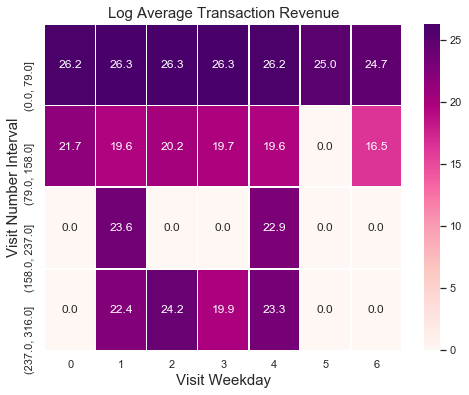

In [33]:
import seaborn as sns
import calendar
sns.set(rc={'figure.figsize':(8,6)})
american_df = train_df[train_df['geoNetwork.country']=='United States']
transaction_weekday_visnum = american_df[['visit_weekday', 'visitNumber', 'totals.transactionRevenue']]
transaction_weekday_visnum = transaction_weekday_visnum.groupby(['visit_weekday', 
                                                             pd.cut(transaction_weekday_visnum["visitNumber"], 
                                                                    np.arange(0, transaction_weekday_visnum['visitNumber'].max(), transaction_weekday_visnum['visitNumber'].max()/5)).rename('visitnumbin')]).sum()
# transaction_continent_os.rename(columns={'ID':'COUNT','TIME':'MEAN_TIME'})
transaction_weekday_visnum.drop(columns=['visitNumber'], inplace=True)
transaction_weekday_visnum = transaction_weekday_visnum.reset_index()
transaction_weekday_visnum['totals.transactionRevenue'] = np.log1p(transaction_weekday_visnum['totals.transactionRevenue'])
twv_pivot = transaction_weekday_visnum.pivot('visitnumbin', 'visit_weekday', 'totals.transactionRevenue')
# twv_pivot.head()
# transaction_weekday_visnum.head()
plt.title('Log Average Transaction Revenue', size = 15)
sns.heatmap(twv_pivot, annot=True, fmt=".1f", linewidths=.5, square = False, cmap = 'RdPu')
plt.xlabel('Visit Weekday', size = 15)
plt.ylabel('Visit Number Interval', size = 15)

Text(0.5, 1.0, 'Log Transaction Revenue of Weekdays')

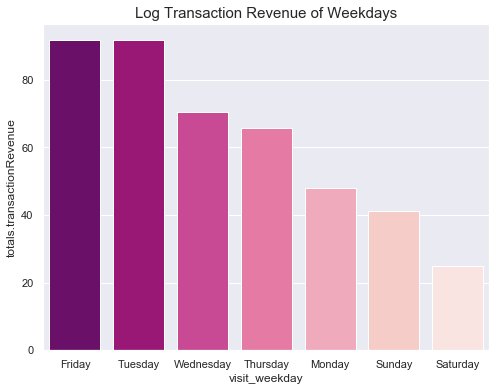

In [32]:
# transaction_weekday_visnum['totals.transactionRevenue'] = np.exp(transaction_weekday_visnum['totals.transactionRevenue']) - 1
transaction_weekday = transaction_weekday_visnum.groupby(['visit_weekday']).sum()
transaction_weekday.head()
transaction_weekday = transaction_weekday.reset_index()
worder = transaction_weekday.sort_values('totals.transactionRevenue', ascending=False)
twg = sns.barplot(x='visit_weekday', y='totals.transactionRevenue', data=transaction_weekday, palette=sns.color_palette("RdPu_r", 7), order=worder['visit_weekday'])
twg.set(xticklabels = [list(calendar.day_name)[int(i)] for i in worder.visit_weekday])
twg.set_title("Log Transaction Revenue of Weekdays", size=15)

[[Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Monday'),
  Text(0, 0, 'Friday'),
  Text(0, 0, 'Saturday'),
  Text(0, 0, 'Sunday')]]

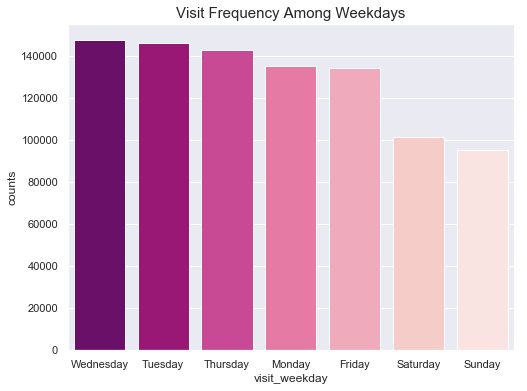

In [33]:
hit_weekday = train_df[['visit_weekday']].groupby(['visit_weekday']).size().reset_index()
hit_weekday.rename(columns={0:'counts'}, inplace=True)
hit_weekday.head()
hworder = hit_weekday.sort_values(['counts'], ascending=False)
hwg = sns.barplot(x='visit_weekday', y='counts', data=hit_weekday, palette=sns.color_palette("RdPu_r", 7), order=hworder['visit_weekday'])
hwg.set_title("Visit Frequency Among Weekdays", size=15)
hwg.set(xticklabels = [list(calendar.day_name)[int(i)] for i in hworder.visit_weekday])

**Transaction revenue is correlated with days of a week.** 
From both of the three plots, I observe that people more tend to explore online stores from Tuesday to Friday than the weekend, especially the store which they have visited for many times. 
People are hanging out on Saturdays and Sundays so there is less transcation revenue. 
On normal weekdays people get off work and open their devices to have a look of these stores. They can even open it everytime and everywhere during a day if they have a short rest. 
Interestingly, people explore less on Monday. The first day of a week usually has a lot of work to do and their bosses may watching them for not deserting. 

**It seems that costomers have a peak shopping efficiency on Friday** because the frequency of visiting online stores on Friday is in the 5th place, however, the transaction revenue on that day almost riches the same value as Wednesday which is in the first place. This could be explained by people's action being affected by emotion. People think Friday is the last day they have to work so they usually have a more excited mood. They are impetuous to buy more with less exploration.

Also, **transaction revenue is correlated with times of a customer visiting**. The stores visited by people more frequently have more chances to make a deal with higher transaction revenue. This could be interpreted as a kind of trust from frequent guests. But, there is a small counter phenomenon on Friday. People on Saturday and Sunday who are still sticked to their devices might be veterans in online shopping. Their exploration on stores they had never been to is hunting for big sales!

## 3 Geographic Information
I choose `geoNetwork.continent`, `device.deviceCategory` and `totals.transactionRevenue` to explore geographic information. I want to figure out the preference of online shopping methods among different continents. What's more, I'm interested in whether the shopping method will influence the transaction revenue.

As a result, I plot these values on a heatmap and bar charts.

First, plot the average log transaction revenue from different devices in continents.

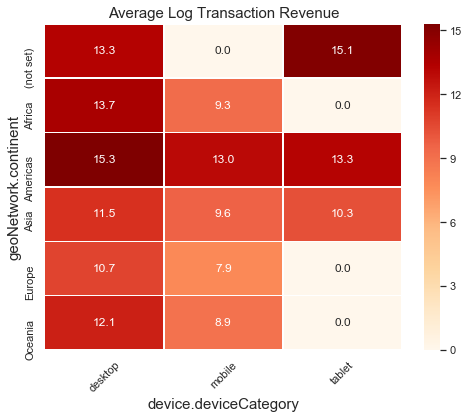

In [34]:
transaction_mobile_continent = train_df[['geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue']]
transaction_mobile_continent = transaction_mobile_continent.groupby(['geoNetwork.continent', 'device.deviceCategory']).mean()
transaction_mobile_continent = transaction_mobile_continent.reset_index()
transaction_mobile_continent['totals.transactionRevenue'] = np.log1p(transaction_mobile_continent['totals.transactionRevenue'])
tmc_pivot = transaction_mobile_continent.pivot('geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue')
plt.xlabel('Device Category', size = 15)
plt.ylabel('Continent', size = 15)
plt.xticks(rotation=45)
plt.title('Average Log Transaction Revenue', size = 15)
sns.heatmap(tmc_pivot, annot=True, fmt=".1f", linewidths=.5, square = False, cmap = 'OrRd')

Then, plot the ratio of device usage within each continent.

Text(0.5, 1.0, 'Device Usage Ratio')

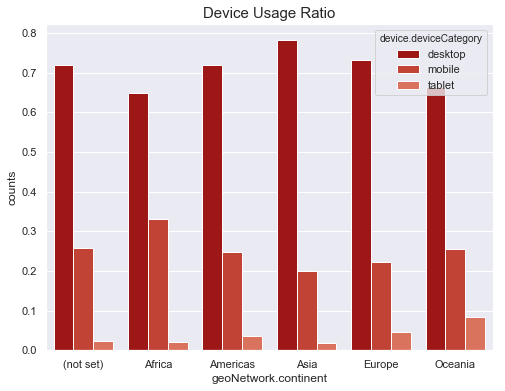

In [35]:
geo_device = train_df[['geoNetwork.continent', 'device.deviceCategory']].groupby(['geoNetwork.continent', 'device.deviceCategory']).size().reset_index()
geo_device.rename(columns={0:'counts'}, inplace=True)
for cname in set(geo_device['geoNetwork.continent'].values):
    s = geo_device['counts'][geo_device['geoNetwork.continent']==cname].sum()
    geo_device['counts'].loc[geo_device['geoNetwork.continent']==cname] = geo_device['counts'][geo_device['geoNetwork.continent']==cname]/s
# geo_device.head()
gdg = sns.barplot(x="geoNetwork.continent", y='counts', hue="device.deviceCategory", data=geo_device, palette=sns.color_palette("OrRd_r", 7))
gdg.set_title("Device Usage Ratio", size=15)

Finally, plot the average trasaction revenue made by different devices among continents. Note that here I only consider the success transactions, which means the transaction revenue should be greater than 0. The reason why I do so is to see for thoes who really buy something, is their any difference between devices they use.

Text(0.5, 1.0, 'Device Average Transaction Revenue of Success Transactinos')

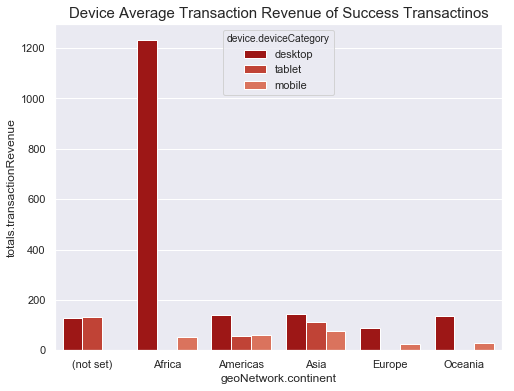

In [36]:
geo_device_t = train_df[['geoNetwork.continent', 'device.deviceCategory', 'totals.transactionRevenue']][train_df['totals.transactionRevenue']>0].groupby(['geoNetwork.continent', 'device.deviceCategory']).mean().reset_index()
geo_device_t['totals.transactionRevenue'] = geo_device_t['totals.transactionRevenue']/(10**6)
gdtg = sns.barplot(x="geoNetwork.continent", y='totals.transactionRevenue', hue="device.deviceCategory", data=geo_device_t, palette=sns.color_palette("OrRd_r", 7))
gdtg.set_title("Device Average Transaction Revenue of Success Transactinos", size=15)

From the plots above I obtain the information that **people all round the world are more likely to use desktop devices to shop online**. The distributions of device usage in different continents are **similar**. 

Specifically, African people use mobile devices more than others, but actually, those who use desktop devices buy goods **much more valuable** than the mobile. This can be explained by the popularize of mobile devices as well as **the extremely large gap between the rich and the poor in Africa**. 

Asian people use tablet least but those tablet users contribute more average revenue than the mobile. 

It's fun to figure out from those plots that people like to **buy more expansive stuff by using larger devices**. This is due to the both techincal stability and reliablity, and psycological security of desktop devices. I speculate that people using desktop think they won't **be frauded**, and **abundant details and reviews** from other customers about the item on the screen will let them more confident to decide buying an expansive item.

## 4 Buying score

A score, no matter it is a buying score or a selling score, is aimed to establish an easy way to evaluate the sample based on a set of features. It represents 

Do some statistic work to figure out which users are likely to buy. Here I use the times of buying things / times of viewing the shop as the probability. Associated with the transaction revenue, I sort them in descending order to define who is the customer with the highest probability to buy.

In [29]:
times_of_buy = train_df[['fullVisitorId', 'totals.transactionRevenue']]
times_of_buy['buy_time']=0
times_of_buy.loc[times_of_buy['totals.transactionRevenue']>0,'buy_time'] = 1
times_of_buy = times_of_buy.groupby(['fullVisitorId']).sum().reset_index()
# times_of_buy
times_of_buy.sort_values('fullVisitorId', inplace=True)
times_of_visit = train_df[['fullVisitorId']].groupby(['fullVisitorId']).size().reset_index()
times_of_visit.rename(columns={0: 'counts'}, inplace=True)
times_of_visit.sort_values('fullVisitorId', inplace=True)
# times_of_visit.describe()
# times_of_buy.describe()
buy_prob = pd.DataFrame({'fullVisitorId': times_of_buy.fullVisitorId.values,
                         'prob':(times_of_buy['buy_time'] / times_of_visit.counts).values,
                         'totals.transactionRevenue': times_of_buy['totals.transactionRevenue'].values})
buy_prob.sort_values(['prob', 'totals.transactionRevenue'], ascending=False, inplace=True)
buy_prob[buy_prob['prob']>=1.0]

,fullVisitorId,prob,totals.transactionRevenue
339476,4759981878863963838,1.0,3.026100e+09
576696,8076486872734382011,1.0,2.438870e+09
625263,875410720669459903,1.0,2.407200e+09
214457,3006489767948351126,1.0,2.211380e+09
315409,4422460864147269736,1.0,1.960720e+09
279744,3924372865099736100,1.0,1.720930e+09
225089,3156235512146749592,1.0,1.604650e+09
103633,145862566057652583,1.0,1.600200e+09
651922,9127657904050953509,1.0,1.564270e+09
507944,7117209037706583763,1.0,1.534410e+09


At first, I want to plot the numeric variables to see their correlation.

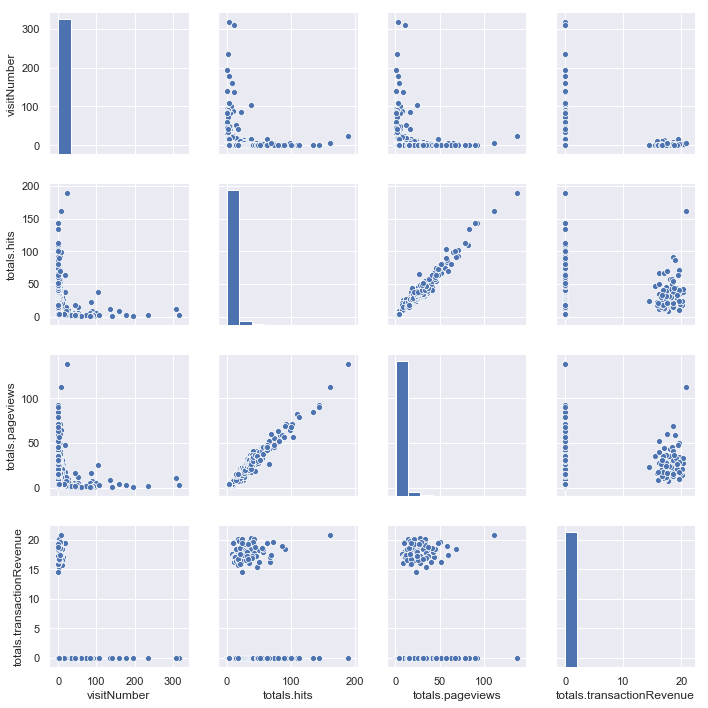

In [38]:
sns.set(rc={'figure.figsize':(16,12)})
nfs = train_df[NUM_FEATURE_NAMES+['totals.transactionRevenue']]
nfs['totals.transactionRevenue'] = np.log1p(nfs['totals.transactionRevenue'])
nfs.describe()
nfs_g = sns.pairplot(nfs[:10000])

It seems that `totals.pageviews` and `totals.hits` have a strong correlation. They are almost the same.

Let's have clearer plots considering the transactions with revenue > 0 and = 0 respectively.

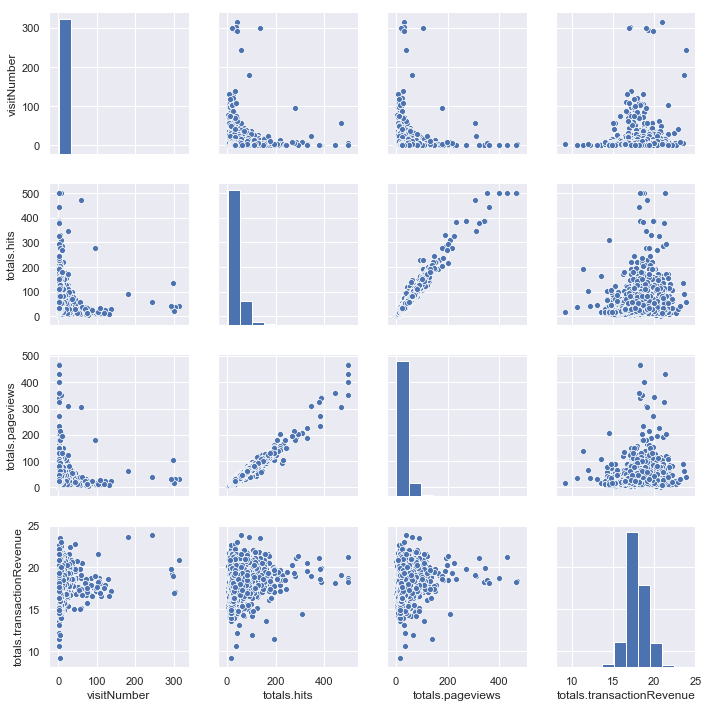

In [34]:
nfs = train_df[train_df['totals.transactionRevenue']>0][NUM_FEATURE_NAMES+['totals.transactionRevenue']]
nfs['totals.transactionRevenue'] = np.log1p(nfs['totals.transactionRevenue'])
nfs.describe()
nfs_g = sns.pairplot(nfs[:10000])

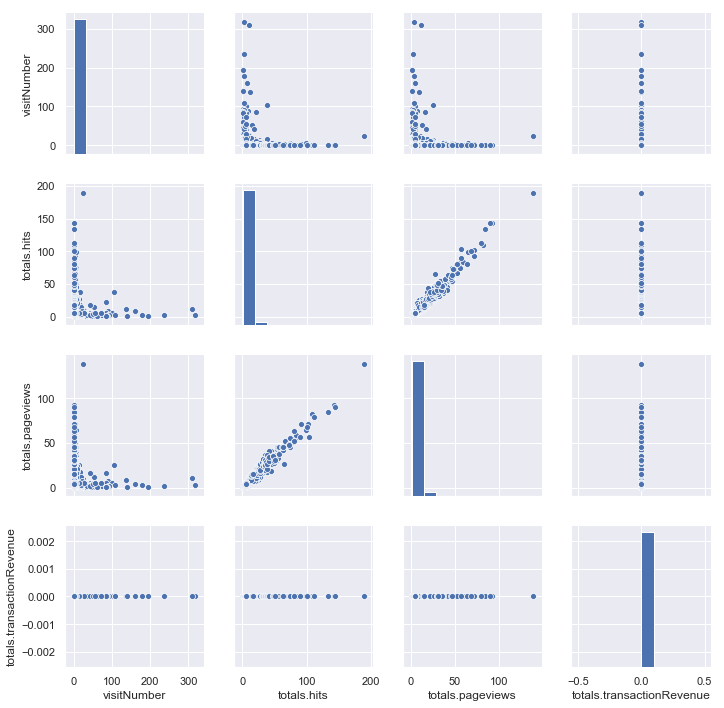

In [36]:
nfs = train_df[train_df['totals.transactionRevenue']==0][NUM_FEATURE_NAMES+['totals.transactionRevenue']]
nfs['totals.transactionRevenue'] = np.log1p(nfs['totals.transactionRevenue'])
nfs.describe()
nfs_g = sns.pairplot(nfs[:10000])

I find that for success transactions:
 - The linear relationship between `totals.hits` and `totals.pageviews` is weaker than zero transactions. If we do a simple linear regression, their ratio tends to be $1.3$ if a revenue >0 and be $1.0$ if revenue = 0.
 - The ranges of `totals.hits` and `totals.pageviews` are wider.
 - If both `visitNumber`, `totals.hits`, `totals.pageviews` have a value at least in small amount greater than 0, it has higher probability for a customer to buy. 
 - If we do a simple linear regression on the relationships between `visitNumber` and `totals.pageview`, `visitNumber` and `totals.hits`, we can find that it is concentrated around $0.5$.
    
As a result, I'd like to define my buying score as:
Define $HPR = \frac{totals.hits}{totals.pageviews}$,

Define $VPR = \frac{visitNumber}{totals.pageviews}$,

Define $VHR = \frac{visitNumber}{totals.hits}$,

Define logistic function $L(x, bias)=\frac{1}{1+e^{k\cdot(bias-x)}}$, where $k$ is set $0.02$

Considering the high correlation revealed in the previous exploration, I set $\alpha=1$ and $\beta=10$ to give a heavy weight on the number of `visitNumber`, `totals.hits` and `totals.pageviews`.

Finally, define probability $P = (\alpha \frac{1}{(1.3-HPR)^2+(0.5-VPR)^2+(0.5-VHR)^2+1} + \beta L(visitNumber, 5) + \beta L(totals.pageviews, 3) + \beta L(totals.hits, 3))/(\alpha + 3\beta)$

Calculate the probability according to the formula:

In [6]:
def logistic(x, bias = 0, k=0.02):
    return 1/(1+np.exp((bias-x)*k))

hpr = (train_df['totals.hits']*1.0+1.5)/(train_df['totals.pageviews']+1)
vpr = (train_df['visitNumber']*1.0+0.5)/(train_df['totals.pageviews']+1)
vhr = (train_df['visitNumber']*1.0+0.5)/(train_df['totals.hits']+1)
# print (hpr.max(), vpr.max(), vhr.max())
p1 = (1/((1.3-hpr)**2+(0.5-vpr)**2+(0.5-vhr)**2+1)).values
# p1 = 1
p2 = logistic(train_df['visitNumber'], 5.0)
p3 = logistic(train_df['totals.pageviews'], 3.0)
p4 = logistic(train_df['totals.hits'], 3.0)
alpha = 1
beta = 10
# print (p1.max(), p2.max(), p3.max(), p4.max())
prob_score = pd.DataFrame({'fullVisitorId': train_df.fullVisitorId.values,
                         'prob':(p1+10*(p2+p3+p4))/(alpha+3*beta)})
prob_score = prob_score.groupby(['fullVisitorId']).mean().reset_index()
prob_score.sort_values('prob', inplace=True, ascending=False)
top_10_score = prob_score[:10]
for i in range(len(top_10_score)):
    print("ID:{}, Score:{}, Rank in Real Prob:{}".format(top_10_score.iloc[i]['fullVisitorId'], top_10_score.iloc[i]['prob'], buy_prob['fullVisitorId'].values.tolist().index(top_10_score.iloc[i]['fullVisitorId'])+1))

NameError: name 'buy_prob' is not defined

Where ID is the `fullVisitorId` of the customer, Score is its buying probability, and Rank in Real Prob is its rank in the ground truth. I think my score is working well to some degree because the top-10 customers include 4 customers who really bought something, ranking at:
 - **6**
 - **693**
 - **78**
 - **26**
 
respectively where 3 of them are in high ranks among more than 3000 people.

The drawback of my score function is not considering as wild as much features like those categorical ones into consideration. 

## 5 External Dataset
 - [City of Average Monthly Net Salary](https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=105) from https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=105 
 - [Property Price](https://www.numbeo.com/property-investment/country_result.jsp) from https://www.numbeo.com/cost-of-living/city_price_rankings?itemId=105
 - [Food Price](https://www.numbeo.com/food-prices/country_result.jsp) from https://www.numbeo.com/food-prices/country_result.jsp
 
It's a good reference for this task to have a preview that a customer having more or less purchasing power. But, the higher income doesn't direcly mean a corresponding purchasing power. With the help of **property price** and **food price**, it's easy to roughly estimate the average **disposable income** of a district by using **net salary** minus food price and a certain type of property price (for example, renting an apartment). The higher purchasing power, the higher probability to make a big deal. 



## 6 Establish a model

In [36]:
train_df = pd.read_csv('data\\w_train.csv', dtype={'fullVisitorId': 'str'})
test_df = pd.read_csv('data\\w_test.csv', dtype={'fullVisitorId': 'str'})

In [37]:
np.log1p(train_df["totals.transactionRevenue"][train_df["totals.transactionRevenue"]>0]).describe()

count    11515.000000
mean        17.823362
std          1.202494
min          9.210440
25%         17.031582
50%         17.716473
75%         18.494442
max         23.864375
Name: totals.transactionRevenue, dtype: float64

In [38]:
train_df["totals.transactionRevenue"][train_df["totals.transactionRevenue"]>0].describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [39]:
remove_list = ['geoNetwork.continent', 'trafficSource.adwordsClickInfo.slot',
               'trafficSource.adContent', 'visit_year', 'trafficSource.adwordsClickInfo.page',
               'totals.newVisits', 'channelGrouping', 'device.isMobile', 'trafficSource.medium',
               'device.deviceCategory', 'geoNetwork.subContinent', 'trafficSource.keyword', 'device.browser',
               'visit_weekday']
for name in remove_list:
    try:
        FEATURE_COLUMN_NAMES.remove(name)
    except:
        continue
for name in remove_list:
    try:
        CAT_FEATURE_NAMES.remove(name)
    except:
        continue

In [40]:
def get_myscore(df):
    hpr = (df['totals.hits']*1.0+1.5)/(df['totals.pageviews']+1)
    vpr = (df['visitNumber']*1.0+0.5)/(df['totals.pageviews']+1)
    vhr = (df['visitNumber']*1.0+0.5)/(df['totals.hits']+1)
    p1 = (1/((1.3-hpr)**2+(0.5-vpr)**2+(0.5-vhr)**2+1)).values
    p2 = logistic(df['visitNumber'], 5.0)
    p3 = logistic(df['totals.pageviews'], 3.0)
    p4 = logistic(df['totals.hits'], 3.0)
    alpha = 1
    beta = 10
    df['prob_score']=(p1+10*(p2+p3+p4))/(alpha+3*beta)
FEATURE_COLUMN_NAMES = FEATURE_COLUMN_NAMES + ['prob_score']
NUM_FEATURE_NAMES = NUM_FEATURE_NAMES + ['prob_score']
get_myscore(train_df)
get_myscore(test_df)

Label the categorical data into integers and store them for repeating use.

Note that I label the categorical data according to the corresponding rank on the mean of transaction revenue of each category. For example, if category A has a mean transaction revenue of 3 and category B has 4. There are only the two categories. Then, category A will be labeled as 1 and B will be given 2. If there is new category occurring in C, it gains 0.

In [41]:
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder

# unseen: 0
def get_label_dict(df, col):
    rank = df.groupby([col]).mean().reset_index()
    order = rank.sort_values('totals.transactionRevenue', ascending=False)
#     print (order)
    label_dict = {}
    for i in range(1, len(order)+1):
        label_dict[order[col][len(order)-i]] = i
    return label_dict

def map_to_label(value, label_dict):
    return label_dict.get(value, 0)

# def transform_to_label(df, col, label_dict):
#     df[col] = df[col].apply(lambda x: map_to_label(x, label_dict))
#     df[col].astype('int')
#     return df

# label encode the categorical variables and convert the numerical variables to float
# for col in CAT_FEATURE_NAMES:
#     lbl = LabelEncoder()
#     lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
#     train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
#     test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

for col in CAT_FEATURE_NAMES:
    label_dict = get_label_dict(train_df[['totals.transactionRevenue', col]], col)
#     print (label_dict)
    train_df[col] = train_df[col].apply(lambda x: map_to_label(x, label_dict))
    test_df[col] = test_df[col].apply(lambda x: map_to_label(x, label_dict))


for col in NUM_FEATURE_NAMES:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)
    
train_df.head()
train_df.dtypes


Unnamed: 0                                    int64
channelGrouping                              object
fullVisitorId                                object
visitNumber                                 float64
device.browser                               object
device.deviceCategory                        object
device.isMobile                                bool
device.operatingSystem                        int64
geoNetwork.city                               int64
geoNetwork.continent                         object
geoNetwork.country                            int64
geoNetwork.networkDomain                      int64
geoNetwork.subContinent                      object
totals.hits                                 float64
totals.newVisits                              int64
totals.pageviews                            float64
totals.transactionRevenue                   float64
trafficSource.adContent                      object
trafficSource.adwordsClickInfo.isVideoAd      int64
trafficSourc

In [42]:
LABEL_FLAG=True
if LABEL_FLAG:
    train_df.to_csv('data\\l_train_rm.csv', index=False)
    test_df.to_csv('data\\l_test_rm.csv', index=False)

Read the stored labeled data

In [43]:
train_df = pd.read_csv('data\\l_train_rm.csv', dtype={'fullVisitorId': 'str'})
test_df = pd.read_csv('data\\l_test_rm.csv', dtype={'fullVisitorId': 'str'})
test_df.dtypes

Unnamed: 0                                    int64
channelGrouping                              object
fullVisitorId                                object
visitNumber                                 float64
device.browser                               object
device.deviceCategory                        object
device.isMobile                                bool
device.operatingSystem                        int64
geoNetwork.city                               int64
geoNetwork.continent                         object
geoNetwork.country                            int64
geoNetwork.networkDomain                      int64
geoNetwork.subContinent                      object
totals.hits                                 float64
totals.newVisits                            float64
totals.pageviews                            float64
trafficSource.adContent                      object
trafficSource.adwordsClickInfo.isVideoAd      int64
trafficSource.adwordsClickInfo.page         float64
trafficSourc

I merge my designed score function into the features.

In [44]:
import sklearn.model_selection
train_y = np.log1p(train_df["totals.transactionRevenue"].values)
train_id = train_df['fullVisitorId'].values
test_id = test_df['fullVisitorId'].values

dev_X, valid_X, dev_y, valid_y = sl.model_selection.train_test_split(
    train_df[FEATURE_COLUMN_NAMES+['fullVisitorId', 'totals.transactionRevenue']], train_y, train_size=0.8, random_state=1)
valid_ids = valid_X["fullVisitorId"].values
valid_transactions = valid_X["totals.transactionRevenue"].values
dev_X.drop(columns=['fullVisitorId', 'totals.transactionRevenue'], inplace=True)
valid_X.drop(columns=['fullVisitorId', 'totals.transactionRevenue'], inplace=True)
test_X = test_df[FEATURE_COLUMN_NAMES]

In [57]:
def run_lgb(train_X, train_y, val_X, val_y, test_X, mode='train'):
    params = {
        "objective" : "regression",
        'nthread': 16,
        "num_leaves" : 100,
        "metric" : "rmse", 
        "learning_rate" : 0.002,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_seed" : 519,
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 100,
        'scale_pos_weight':1,
        "verbosity" : -1
    }
    
    lgtrain = lgbm.Dataset(train_X, label=train_y, feature_name=FEATURE_COLUMN_NAMES, categorical_feature=CAT_FEATURE_NAMES)
    lgval = lgbm.Dataset(val_X, label=val_y, feature_name=FEATURE_COLUMN_NAMES, categorical_feature=CAT_FEATURE_NAMES)
    model = lgbm.train(params, lgtrain, 20000, valid_sets=[lgval], early_stopping_rounds=1000, verbose_eval=2000)
    
    if mode=='train':
        pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
        pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    elif mode=='permutation':
        pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
        pred_test_y=0
    return pred_test_y, model, pred_val_y

In [58]:
from sklearn import linear_model
def run_linear_reg(train_X, train_y, val_X, val_y, test_X, mode='train'):
    model = linear_model.Lasso(alpha=0.4)
    model.fit(train_X, train_y)
    if mode=='train':
        pred_test_y = model.predict(test_X)
        pred_val_y = model.predict(val_X)
    elif mode=='permutation':
        pred_val_y = model.predict(val_X)
        pred_test_y=0
    return pred_test_y, model, pred_val_y

In [59]:
from sklearn import metrics
import time
def gen_submission(pred_test, model, pred_val, valid_X, valid_y, modelname=''):
    pred_val[pred_val<0] = 0
    valid_pred_X = pd.DataFrame({"fullVisitorId":valid_ids})
    valid_pred_X["transactionRevenue"] = valid_transactions
    valid_pred_X["PredictedRevenue"] = np.expm1(pred_val)
    valid_pred_X = valid_pred_X.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
#     valid_pred_X.loc[(valid_pred_X["PredictedRevenue"]<1e4) & (valid_pred_X["PredictedRevenue"]>0), "PredictedRevenue"] = 1e4
    validrmse = np.sqrt(metrics.mean_squared_error(np.log1p(valid_pred_X["transactionRevenue"].values), np.log1p(valid_pred_X["PredictedRevenue"].values)))
    sub_df = pd.DataFrame({"fullVisitorId":test_id})
    pred_test[pred_test<0] = 0
    sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
    sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
#     sub_df.loc[(sub_df["PredictedLogRevenue"]<1e4) & (sub_df["PredictedLogRevenue"]>0), "PredictedLogRevenue"] = 1e4
    sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
    sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
#     sub_df.shape
#     len(sub_df.fullVisitorId.unique())
    print ("Valid RMSE:", validrmse)
    timestr = str(time.time())
    sub_df.to_csv("predict\\{}_{}.csv".format(timestr, modelname), index=False)
    with open("predict\\{}_{}_features.txt".format(timestr, modelname), 'w') as f:
        f.write(', '.join(FEATURE_COLUMN_NAMES)+
                '\n{} model'.format(modelname)+
                '\n{} valid rmse'.format(validrmse))
        f.close()

In [60]:
import lightgbm as lgbm
LGBM_pred_test, LGBM_model, LGBM_pred_val = run_lgb(dev_X, dev_y, valid_X, valid_y, test_X)

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's rmse: 1.60829
[4000]	valid_0's rmse: 1.59842
Early stopping, best iteration is:
[4087]	valid_0's rmse: 1.59835


Looking at whether the model learn the distribution of the target.

In [61]:
gen_submission(LGBM_pred_test, LGBM_model, LGBM_pred_val, valid_X, valid_y, 'LGBM')
lpvg0 = pd.Series(LGBM_pred_val)
lpvg0 = lpvg0[lpvg0 > 0]
lpvg0.describe()

Valid RMSE: 1.593989352129726


count    7.193500e+04
mean     5.804895e-01
std      1.797773e+00
min      1.847095e-07
25%      1.916548e-03
50%      6.232772e-03
75%      5.213186e-02
max      1.750632e+01
dtype: float64

In [124]:
lptg0 = pd.Series(LGBM_pred_test)
lptg0 = lptg0[lptg0 > 0]
lptg0.describe()

count    3.438330e+05
mean     3.766816e-01
std      1.243972e+00
min      3.158986e-07
25%      3.795805e-03
50%      1.045385e-02
75%      1.053789e-01
max      1.666004e+01
dtype: float64

In [125]:
pvg0 = pd.Series(np.log1p(valid_transactions))
pvg0 = pvg0[pvg0>0]
pvg0.describe()

count    2293.000000
mean       17.847121
std         1.199837
min        11.982935
25%        17.033986
50%        17.746944
75%        18.515900
max        23.605577
dtype: float64

## 7 Permutation Test

I do the permutation test on all the features, 100 rounds of shuffles each feature due to the running time of LGBM model. Even though it only needs about 6s to train a model, more than 20 features and 1000 rounds cost a lot. As a result, I only perform 100 rounds. Each round generates a new model and gets its validation RMSE based on the validation set. Note that the validation set is not involved in the shuffling.

In [136]:
# np.random.seed(519)
def shuffle_value(X, feature):
    n = len(X[feature])
    X[feature] = sl.utils.shuffle(X[feature].values.copy())
    return X
def permutation_test(dev_X, dev_y, valid_X, valid_y, test_X, modelname='', n_shuffle=1000):
    error_dict = {}
    for feature in FEATURE_COLUMN_NAMES:
#     for feature in NUM_FEATURE_NAMES:
        copy_dev_X = dev_X.copy(deep=True)
        error_dict[feature]= []
        print ("Permutation Test on {}".format(feature))
        for i in range(n_shuffle):
#             print (dev_X[feature].head())
            s_dev_X = shuffle_value(copy_dev_X, feature)
#             print (s_dev_X[feature].head())
            if modelname=='LGBM':
                pred_test, model, pred_val = run_lgb(s_dev_X, dev_y, valid_X, valid_y, test_X, mode='permutation')
            elif modelname=='LR':
                pred_test, model, pred_val = run_linear_reg(s_dev_X, dev_y, valid_X, valid_y, test_X, mode='permutation')
            pred_val[pred_val<0] = 0
            valid_pred_X = pd.DataFrame({"fullVisitorId":valid_ids})
            valid_pred_X["transactionRevenue"] = valid_transactions
            valid_pred_X["PredictedRevenue"] = np.expm1(pred_val)
            valid_pred_X = valid_pred_X.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
            validrmse = np.sqrt(metrics.mean_squared_error(np.log1p(valid_pred_X["transactionRevenue"].values), np.log1p(valid_pred_X["PredictedRevenue"].values)))
            error_dict[feature].append(validrmse)
            del s_dev_X, pred_test, model, pred_val, valid_pred_X
            if i%10 == 0:
                print ("Round {}: {}".format(i+1, validrmse))
        del copy_dev_X
    return error_dict

In [137]:
import warnings
warnings.filterwarnings('ignore')
LGBM_permu_dict = permutation_test(dev_X, dev_y, valid_X, valid_y, test_X, modelname='LGBM', n_shuffle=100)

Permutation Test on channelGrouping
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[706]	valid_0's rmse: 1.6035
Round 1: 1.5945027102391462
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	valid_0's rmse: 1.60418
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60445
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.6044
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[569]	valid_0's rmse: 1.60302
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[548]	valid_0's rmse: 1.60461
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[465]	valid_0's rmse: 1.60483
Training until validation scores don't imp

Early stopping, best iteration is:
[667]	valid_0's rmse: 1.60252
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[670]	valid_0's rmse: 1.60385
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[518]	valid_0's rmse: 1.60539
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[665]	valid_0's rmse: 1.60352
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60362
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[489]	valid_0's rmse: 1.60444
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[489]	valid_0's rmse: 1.60413
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[662]	valid_0's rmse: 1.60424
Training until validation scores don't 

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60604
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60778
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60553
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[431]	valid_0's rmse: 1.60732
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[556]	valid_0's rmse: 1.6061
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60586
Round 31: 1.5988380311226553
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[448]	valid_0's rmse: 1.60744
Training until validation scores don't improve for 100 rounds.
Early stoppin

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[453]	valid_0's rmse: 1.60688
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[479]	valid_0's rmse: 1.60629
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[448]	valid_0's rmse: 1.60412
Round 91: 1.597496003901117
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[566]	valid_0's rmse: 1.60496
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[510]	valid_0's rmse: 1.60639
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[430]	valid_0's rmse: 1.60746
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	valid_0's rmse: 1.60628
Training until validation scores don't improve for 100 rounds.
Early stoppin

Early stopping, best iteration is:
[501]	valid_0's rmse: 1.60361
Round 51: 1.5975596368101361
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[521]	valid_0's rmse: 1.60444
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[514]	valid_0's rmse: 1.60343
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60572
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.6039
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[525]	valid_0's rmse: 1.60441
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[501]	valid_0's rmse: 1.60368
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[459]	valid_0's rmse: 1.60466
Training un

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[256]	valid_0's rmse: 1.60687
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60347
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[514]	valid_0's rmse: 1.60442
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[498]	valid_0's rmse: 1.60407
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[463]	valid_0's rmse: 1.6056
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[462]	valid_0's rmse: 1.60436
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60623
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[689]	v

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[575]	valid_0's rmse: 1.60279
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60331
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	valid_0's rmse: 1.60388
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[456]	valid_0's rmse: 1.60324
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 1.60325
Round 81: 1.5967238455149462
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[656]	valid_0's rmse: 1.60236
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[552]	valid_0's rmse: 1.60372
Training until validation scores don't improve for 100 rounds.
Early stoppi

Early stopping, best iteration is:
[551]	valid_0's rmse: 1.60376
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60463
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60394
Round 41: 1.5976929508272817
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[572]	valid_0's rmse: 1.60287
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.60304
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[469]	valid_0's rmse: 1.60445
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[500]	valid_0's rmse: 1.6038
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[514]	valid_0's rmse: 1.60483
Training un

Round 1: 1.599736796229984
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60541
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[614]	valid_0's rmse: 1.60734
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[521]	valid_0's rmse: 1.60636
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[549]	valid_0's rmse: 1.60826
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[521]	valid_0's rmse: 1.60667
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60511
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[560]	valid_0's rmse: 1.6075
Training until validation scores don't improve for 100 rounds.
Early stopping,

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60762
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[562]	valid_0's rmse: 1.60565
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[706]	valid_0's rmse: 1.60501
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.60652
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[489]	valid_0's rmse: 1.60614
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[497]	valid_0's rmse: 1.60708
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[497]	valid_0's rmse: 1.60559
Round 71: 1.5983751289220476
Training until validation scores don't improve for 100 rounds.
Early stoppi

Early stopping, best iteration is:
[510]	valid_0's rmse: 1.62042
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.62177
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[498]	valid_0's rmse: 1.62031
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[478]	valid_0's rmse: 1.61526
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.61838
Round 31: 1.6132341580817917
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.62525
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[492]	valid_0's rmse: 1.61964
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[470]	valid_0's rmse: 1.61578
Training u

Early stopping, best iteration is:
[512]	valid_0's rmse: 1.62389
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.62117
Round 91: 1.616297292095622
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[272]	valid_0's rmse: 1.62569
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[271]	valid_0's rmse: 1.62473
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[576]	valid_0's rmse: 1.62269
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[510]	valid_0's rmse: 1.62417
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[565]	valid_0's rmse: 1.61737
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[481]	valid_0's rmse: 1.61849
Training un

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[512]	valid_0's rmse: 1.60433
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60332
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[658]	valid_0's rmse: 1.60323
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[659]	valid_0's rmse: 1.60442
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[701]	valid_0's rmse: 1.60388
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60322
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[638]	valid_0's rmse: 1.60185
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[479]	

Early stopping, best iteration is:
[549]	valid_0's rmse: 1.60863
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[502]	valid_0's rmse: 1.60946
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[565]	valid_0's rmse: 1.6082
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[717]	valid_0's rmse: 1.60824
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 1.60867
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 1.6075
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[506]	valid_0's rmse: 1.60836
Round 21: 1.6012864060133634
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60974
Training unt

Early stopping, best iteration is:
[718]	valid_0's rmse: 1.60898
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[650]	valid_0's rmse: 1.60803
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.60798
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60653
Round 81: 1.600095240816729
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[713]	valid_0's rmse: 1.60667
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[721]	valid_0's rmse: 1.60823
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[665]	valid_0's rmse: 1.60695
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[699]	valid_0's rmse: 1.60612
Training un

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[625]	valid_0's rmse: 1.60633
Round 41: 1.600070693552569
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[666]	valid_0's rmse: 1.60657
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[462]	valid_0's rmse: 1.60739
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[469]	valid_0's rmse: 1.60576
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	valid_0's rmse: 1.60914
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[252]	valid_0's rmse: 1.61104
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[441]	valid_0's rmse: 1.60924
Training until validation scores don't improve for 100 rounds.
Early stoppin

Early stopping, best iteration is:
[553]	valid_0's rmse: 1.60476
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[487]	valid_0's rmse: 1.60454
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[659]	valid_0's rmse: 1.60241
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[456]	valid_0's rmse: 1.60493
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[512]	valid_0's rmse: 1.60412
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[669]	valid_0's rmse: 1.604
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60399
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60476
Training until validation scores don't im

Early stopping, best iteration is:
[499]	valid_0's rmse: 1.60478
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[562]	valid_0's rmse: 1.60288
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[489]	valid_0's rmse: 1.60465
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[500]	valid_0's rmse: 1.60331
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[660]	valid_0's rmse: 1.60448
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[689]	valid_0's rmse: 1.60384
Round 71: 1.5961275620061228
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.60423
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[708]	valid_0's rmse: 1.60244
Training u

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.6324
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[236]	valid_0's rmse: 1.63187
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[231]	valid_0's rmse: 1.63226
Round 31: 1.6275503253571284
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[270]	valid_0's rmse: 1.63199
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[331]	valid_0's rmse: 1.63244
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[233]	valid_0's rmse: 1.63298
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	valid_0's rmse: 1.63294
Training until validation scores don't improve for 100 rounds.
Early stoppin

Round 91: 1.6283102746584905
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[217]	valid_0's rmse: 1.63315
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	valid_0's rmse: 1.63157
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[260]	valid_0's rmse: 1.63187
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[231]	valid_0's rmse: 1.63192
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[234]	valid_0's rmse: 1.63281
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	valid_0's rmse: 1.63246
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[323]	valid_0's rmse: 1.6315
Training until validation scores don't improve for 100 rounds.
Early stoppin

Early stopping, best iteration is:
[629]	valid_0's rmse: 1.60292
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[656]	valid_0's rmse: 1.60186
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[707]	valid_0's rmse: 1.60264
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[469]	valid_0's rmse: 1.60419
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[497]	valid_0's rmse: 1.60436
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60528
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[525]	valid_0's rmse: 1.60285
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[494]	valid_0's rmse: 1.60195
Round 61: 1.5955963390320553
Training u

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[247]	valid_0's rmse: 1.66865
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	valid_0's rmse: 1.6691
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[244]	valid_0's rmse: 1.66935
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	valid_0's rmse: 1.6693
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[317]	valid_0's rmse: 1.66978
Round 21: 1.6660849627903485
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[277]	valid_0's rmse: 1.66996
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	valid_0's rmse: 1.66946
Training until validation scores don't improve for 100 rounds.
Early stopping

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[249]	valid_0's rmse: 1.67093
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[246]	valid_0's rmse: 1.67013
Round 81: 1.666953345395225
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[362]	valid_0's rmse: 1.6699
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[246]	valid_0's rmse: 1.67029
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[249]	valid_0's rmse: 1.66802
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[226]	valid_0's rmse: 1.66941
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[224]	valid_0's rmse: 1.66943
Training until validation scores don't improve for 100 rounds.
Early stopping

Early stopping, best iteration is:
[518]	valid_0's rmse: 1.60315
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[525]	valid_0's rmse: 1.60274
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[561]	valid_0's rmse: 1.60276
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[627]	valid_0's rmse: 1.60278
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[537]	valid_0's rmse: 1.60258
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.60315
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[687]	valid_0's rmse: 1.60271
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[671]	valid_0's rmse: 1.6024
Training until validation scores don't i

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Round 11: 1.5961265431080773
Training until validation scores don't improve for 100 rounds.
Early stoppi

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Round 71: 1.5961265431080773
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stoppi

Early stopping, best iteration is:
[499]	valid_0's rmse: 1.60408
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[656]	valid_0's rmse: 1.60236
Round 31: 1.5952671363488042
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	valid_0's rmse: 1.60355
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.60325
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	valid_0's rmse: 1.60206
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[683]	valid_0's rmse: 1.60174
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[721]	valid_0's rmse: 1.60176
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[501]	valid_0's rmse: 1.604
Training unt

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[666]	valid_0's rmse: 1.60396
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[487]	valid_0's rmse: 1.60346
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[481]	valid_0's rmse: 1.60343
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[645]	valid_0's rmse: 1.6035
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[500]	valid_0's rmse: 1.60394
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[607]	valid_0's rmse: 1.60359
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[499]	valid_0's rmse: 1.60278
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[626]	v

Early stopping, best iteration is:
[666]	valid_0's rmse: 1.60185
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60258
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[663]	valid_0's rmse: 1.60333
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[670]	valid_0's rmse: 1.60219
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[671]	valid_0's rmse: 1.60143
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[671]	valid_0's rmse: 1.60409
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[667]	valid_0's rmse: 1.60249
Round 61: 1.5950687537850288
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60348
Training u

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Round 21: 1.5961265431080773
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stoppi

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Round 81: 1.5961265431080773
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.60321
Training until validation scores don't improve for 100 rounds.
Early stoppi

Early stopping, best iteration is:
[525]	valid_0's rmse: 1.60436
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[626]	valid_0's rmse: 1.6036
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[694]	valid_0's rmse: 1.60369
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[498]	valid_0's rmse: 1.60532
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[464]	valid_0's rmse: 1.60417
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[684]	valid_0's rmse: 1.60322
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[662]	valid_0's rmse: 1.60522
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[497]	valid_0's rmse: 1.60242
Training until validation scores don't i

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[565]	valid_0's rmse: 1.60497
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[497]	valid_0's rmse: 1.60509
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[681]	valid_0's rmse: 1.60325
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[673]	valid_0's rmse: 1.60447
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[550]	valid_0's rmse: 1.60274
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60492
Round 11: 1.598952667876716
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[465]	valid_0's rmse: 1.60486
Training until validation scores don't improve for 100 rounds.
Early stoppin

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	valid_0's rmse: 1.60272
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[659]	valid_0's rmse: 1.60269
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[666]	valid_0's rmse: 1.60106
Round 71: 1.5937222333944252
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60447
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[491]	valid_0's rmse: 1.60432
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[687]	valid_0's rmse: 1.60324
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60453
Training until validation scores don't improve for 100 rounds.
Early stoppi

Early stopping, best iteration is:
[551]	valid_0's rmse: 1.60653
Round 31: 1.6003470018712105
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[685]	valid_0's rmse: 1.60624
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60629
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[510]	valid_0's rmse: 1.60733
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[657]	valid_0's rmse: 1.60673
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[501]	valid_0's rmse: 1.60631
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60675
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[559]	valid_0's rmse: 1.60737
Training u

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60782
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[458]	valid_0's rmse: 1.60583
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[498]	valid_0's rmse: 1.6058
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[453]	valid_0's rmse: 1.60908
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[636]	valid_0's rmse: 1.60717
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[511]	valid_0's rmse: 1.60894
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60832
Permutation Test on visit_year
Training until validation scores don't improve for 100 rounds.
Early stopp

Early stopping, best iteration is:
[683]	valid_0's rmse: 1.60318
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.60347
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[500]	valid_0's rmse: 1.60414
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[758]	valid_0's rmse: 1.60292
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[501]	valid_0's rmse: 1.60324
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[473]	valid_0's rmse: 1.60388
Round 61: 1.5969670401142462
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[655]	valid_0's rmse: 1.60286
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60412
Training u

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[559]	valid_0's rmse: 1.61233
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[463]	valid_0's rmse: 1.61373
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[571]	valid_0's rmse: 1.61237
Round 21: 1.6050497216566317
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[465]	valid_0's rmse: 1.61224
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[524]	valid_0's rmse: 1.61275
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[688]	valid_0's rmse: 1.60987
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[474]	valid_0's rmse: 1.61116
Training until validation scores don't improve for 100 rounds.
Early stoppi

Round 81: 1.603449758021817
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[551]	valid_0's rmse: 1.6125
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[518]	valid_0's rmse: 1.612
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[492]	valid_0's rmse: 1.61268
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.61318
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[468]	valid_0's rmse: 1.61229
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[463]	valid_0's rmse: 1.61336
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[491]	valid_0's rmse: 1.61231
Training until validation scores don't improve for 100 rounds.
Early stopping, 

Early stopping, best iteration is:
[575]	valid_0's rmse: 1.60832
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[683]	valid_0's rmse: 1.60627
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[684]	valid_0's rmse: 1.60901
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.61027
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[468]	valid_0's rmse: 1.60724
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[456]	valid_0's rmse: 1.60815
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[497]	valid_0's rmse: 1.60904
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[490]	valid_0's rmse: 1.60707
Round 51: 1.6007260587695207
Training u

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[510]	valid_0's rmse: 1.60816
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[547]	valid_0's rmse: 1.60528
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[565]	valid_0's rmse: 1.6078
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[572]	valid_0's rmse: 1.60682
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[498]	valid_0's rmse: 1.60664
Round 11: 1.5987593060392078
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[485]	valid_0's rmse: 1.60916
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[471]	valid_0's rmse: 1.60712
Training until validation scores don't improve for 100 rounds.
Early stoppin

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[477]	valid_0's rmse: 1.60686
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[486]	valid_0's rmse: 1.60705
Round 71: 1.600108609107854
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[552]	valid_0's rmse: 1.60938
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[478]	valid_0's rmse: 1.60778
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[562]	valid_0's rmse: 1.60748
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[659]	valid_0's rmse: 1.60571
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[543]	valid_0's rmse: 1.60934
Training until validation scores don't improve for 100 rounds.
Early stoppin

Early stopping, best iteration is:
[470]	valid_0's rmse: 1.60425
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[666]	valid_0's rmse: 1.60301
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.60361
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[511]	valid_0's rmse: 1.6053
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[573]	valid_0's rmse: 1.60511
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[465]	valid_0's rmse: 1.60425
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[513]	valid_0's rmse: 1.6046
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[684]	valid_0's rmse: 1.60359
Training until validation scores don't im

Early stopping, best iteration is:
[510]	valid_0's rmse: 1.6045
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[441]	valid_0's rmse: 1.60573
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[629]	valid_0's rmse: 1.60511
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[510]	valid_0's rmse: 1.60507
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[649]	valid_0's rmse: 1.60587
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[472]	valid_0's rmse: 1.60513


In [ ]:
LGBM_permu_dict
# 1.5961265431080773

In [138]:
import json
json.dump(LGBM_permu_dict, open('LGBM_permu_test.json', 'w'), indent=True)

In [131]:
LR_pred_test, LR_model, LR_pred_val = run_linear_reg(dev_X, dev_y, valid_X, valid_y, test_X)

In [132]:
gen_submission(LR_pred_test, LR_model, LR_pred_val, valid_X, valid_y, 'LR')

Valid RMSE: 1.837373507138756


In [129]:
LR_permu_dict = permutation_test(dev_X, dev_y, valid_X, valid_y, test_X, modelname='LR', n_shuffle=10)
import json
json.dump(LR_permu_dict, open('LR_permu_test.json', 'w'), indent=True)

Permutation Test on channelGrouping
32362     4
670880    1
289019    4
681288    4
383766    4
Name: channelGrouping, dtype: int64
32362     1
670880    6
289019    1
681288    4
383766    4
Name: channelGrouping, dtype: int64
Round 1: 1.8319093642998814
32362     4
670880    1
289019    4
681288    4
383766    4
Name: channelGrouping, dtype: int64
32362     2
670880    1
289019    4
681288    2
383766    4
Name: channelGrouping, dtype: int64
Round 2: 1.8319093642998814
32362     4
670880    1
289019    4
681288    4
383766    4
Name: channelGrouping, dtype: int64
32362     1
670880    2
289019    1
681288    4
383766    1
Name: channelGrouping, dtype: int64
Round 3: 1.8319093642998814
32362     4
670880    1
289019    4
681288    4
383766    4
Name: channelGrouping, dtype: int64
32362     4
670880    1
289019    1
681288    3
383766    6
Name: channelGrouping, dtype: int64
Round 4: 1.8319093642998814
32362     4
670880    1
289019    4
681288    4
383766    4
Name: channelGrouping, d

Round 6: 1.8319093642998814
32362     2
670880    3
289019    2
681288    3
383766    3
Name: device.deviceCategory, dtype: int64
32362     3
670880    3
289019    3
681288    3
383766    3
Name: device.deviceCategory, dtype: int64
Round 7: 1.8319093642998814
32362     2
670880    3
289019    2
681288    3
383766    3
Name: device.deviceCategory, dtype: int64
32362     3
670880    3
289019    3
681288    1
383766    3
Name: device.deviceCategory, dtype: int64
Round 8: 1.8319093642998814
32362     2
670880    3
289019    2
681288    3
383766    3
Name: device.deviceCategory, dtype: int64
32362     1
670880    3
289019    3
681288    3
383766    3
Name: device.deviceCategory, dtype: int64
Round 9: 1.8319093642998814
32362     2
670880    3
289019    2
681288    3
383766    3
Name: device.deviceCategory, dtype: int64
32362     3
670880    2
289019    3
681288    2
383766    3
Name: device.deviceCategory, dtype: int64
Round 10: 1.8319093642998814
Permutation Test on device.isMobile
32362  

Round 1: 1.8319093642293018
32362     3
670880    4
289019    3
681288    1
383766    1
Name: geoNetwork.continent, dtype: int64
32362     4
670880    5
289019    4
681288    3
383766    3
Name: geoNetwork.continent, dtype: int64
Round 2: 1.8319093642293018
32362     3
670880    4
289019    3
681288    1
383766    1
Name: geoNetwork.continent, dtype: int64
32362     4
670880    4
289019    2
681288    4
383766    2
Name: geoNetwork.continent, dtype: int64
Round 3: 1.8319093642293018
32362     3
670880    4
289019    3
681288    1
383766    1
Name: geoNetwork.continent, dtype: int64
32362     4
670880    4
289019    2
681288    3
383766    4
Name: geoNetwork.continent, dtype: int64
Round 4: 1.8319093642293018
32362     3
670880    4
289019    3
681288    1
383766    1
Name: geoNetwork.continent, dtype: int64
32362     4
670880    2
289019    4
681288    4
383766    2
Name: geoNetwork.continent, dtype: int64
Round 5: 1.8319093642293018
32362     3
670880    4
289019    3
681288    1
3837

Round 4: 1.831909364297896
32362      7
670880    11
289019     5
681288    22
383766    22
Name: geoNetwork.subContinent, dtype: int64
32362     11
670880    10
289019     5
681288    11
383766    16
Name: geoNetwork.subContinent, dtype: int64
Round 5: 1.831909364297896
32362      7
670880    11
289019     5
681288    22
383766    22
Name: geoNetwork.subContinent, dtype: int64
32362      7
670880    11
289019    11
681288    12
383766     7
Name: geoNetwork.subContinent, dtype: int64
Round 6: 1.831909364297896
32362      7
670880    11
289019     5
681288    22
383766    22
Name: geoNetwork.subContinent, dtype: int64
32362     7
670880    4
289019    7
681288    1
383766    7
Name: geoNetwork.subContinent, dtype: int64
Round 7: 1.831909364297896
32362      7
670880    11
289019     5
681288    22
383766    22
Name: geoNetwork.subContinent, dtype: int64
32362      5
670880     2
289019    11
681288     7
383766     5
Name: geoNetwork.subContinent, dtype: int64
Round 8: 1.83190936429789

Round 9: 1.8543764741712803
32362     3.0
670880    1.0
289019    1.0
681288    1.0
383766    1.0
Name: totals.pageviews, dtype: float64
32362     2.0
670880    2.0
289019    1.0
681288    1.0
383766    1.0
Name: totals.pageviews, dtype: float64
Round 10: 1.8543764741712803
Permutation Test on trafficSource.adContent
32362     45
670880    45
289019    45
681288    45
383766    45
Name: trafficSource.adContent, dtype: int64
32362     45
670880    45
289019    45
681288    45
383766    45
Name: trafficSource.adContent, dtype: int64
Round 1: 1.8319093642998814
32362     45
670880    45
289019    45
681288    45
383766    45
Name: trafficSource.adContent, dtype: int64
32362     45
670880    45
289019    45
681288    45
383766    45
Name: trafficSource.adContent, dtype: int64
Round 2: 1.8319093642998814
32362     45
670880    45
289019    45
681288    45
383766    45
Name: trafficSource.adContent, dtype: int64
32362     45
670880    45
289019    45
681288    45
383766    45
Name: trafficSo

Round 1: 1.8319093642998814
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
Round 2: 1.8319093642998814
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
Round 3: 1.8319093642998814
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
Round 4: 1.8319093642998814
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSource.adwordsClickInfo.slot, dtype: int64
32362     3
670880    3
289019    3
681288    3
383766    3
Name: trafficSou

Round 3: 1.8319093642964934
32362     2
670880    1
289019    2
681288    2
383766    2
Name: trafficSource.medium, dtype: int64
32362     1
670880    4
289019    2
681288    7
383766    7
Name: trafficSource.medium, dtype: int64
Round 4: 1.8319093642964934
32362     2
670880    1
289019    2
681288    2
383766    2
Name: trafficSource.medium, dtype: int64
32362     1
670880    1
289019    2
681288    1
383766    2
Name: trafficSource.medium, dtype: int64
Round 5: 1.8319093642964934
32362     2
670880    1
289019    2
681288    2
383766    2
Name: trafficSource.medium, dtype: int64
32362     1
670880    1
289019    7
681288    2
383766    2
Name: trafficSource.medium, dtype: int64
Round 6: 1.8319093642964934
32362     2
670880    1
289019    2
681288    2
383766    2
Name: trafficSource.medium, dtype: int64
32362     2
670880    2
289019    7
681288    1
383766    2
Name: trafficSource.medium, dtype: int64
Round 7: 1.8319093642964934
32362     2
670880    1
289019    2
681288    2
3837

Round 9: 1.8319093642998814
32362      2
670880    11
289019     2
681288     9
383766     9
Name: visit_month, dtype: int64
32362     8
670880    8
289019    4
681288    8
383766    7
Name: visit_month, dtype: int64
Round 10: 1.8319093642998814
Permutation Test on visit_day
32362      9
670880     8
289019    25
681288    21
383766    28
Name: visit_day, dtype: int64
32362     20
670880    13
289019    24
681288    30
383766     8
Name: visit_day, dtype: int64
Round 1: 1.8319093642998814
32362      9
670880     8
289019    25
681288    21
383766    28
Name: visit_day, dtype: int64
32362      4
670880    15
289019    19
681288    22
383766    18
Name: visit_day, dtype: int64
Round 2: 1.8319093642998814
32362      9
670880     8
289019    25
681288    21
383766    28
Name: visit_day, dtype: int64
32362     15
670880    12
289019    15
681288    29
383766    22
Name: visit_day, dtype: int64
Round 3: 1.8319093642998814
32362      9
670880     8
289019    25
681288    21
383766    28
Name:

In [188]:
LGBM_permu_dict = json.load(open('LGBM_permu_test.json', 'r'))
#valid RMSE for LGBM 1.5961265431080773
RMSE_LGBM = 1.5961265431080773
LR_permu_dict = json.load(open('LR_permu_test.json', 'r'))
#valid RMSE for LR 1.8319093642998814

In [172]:
print (len(LGBM_permu_dict.keys()))

27


In [184]:
def draw_sub_graph_permutation_test(ax, d, k):
    sns.distplot(d, hist=False, color="g", kde_kws={"shade": True}, ax=ax)
    ax.set_title(k)
    ax.axvline(x=RMSE_LGBM, linewidth=3, color='r')

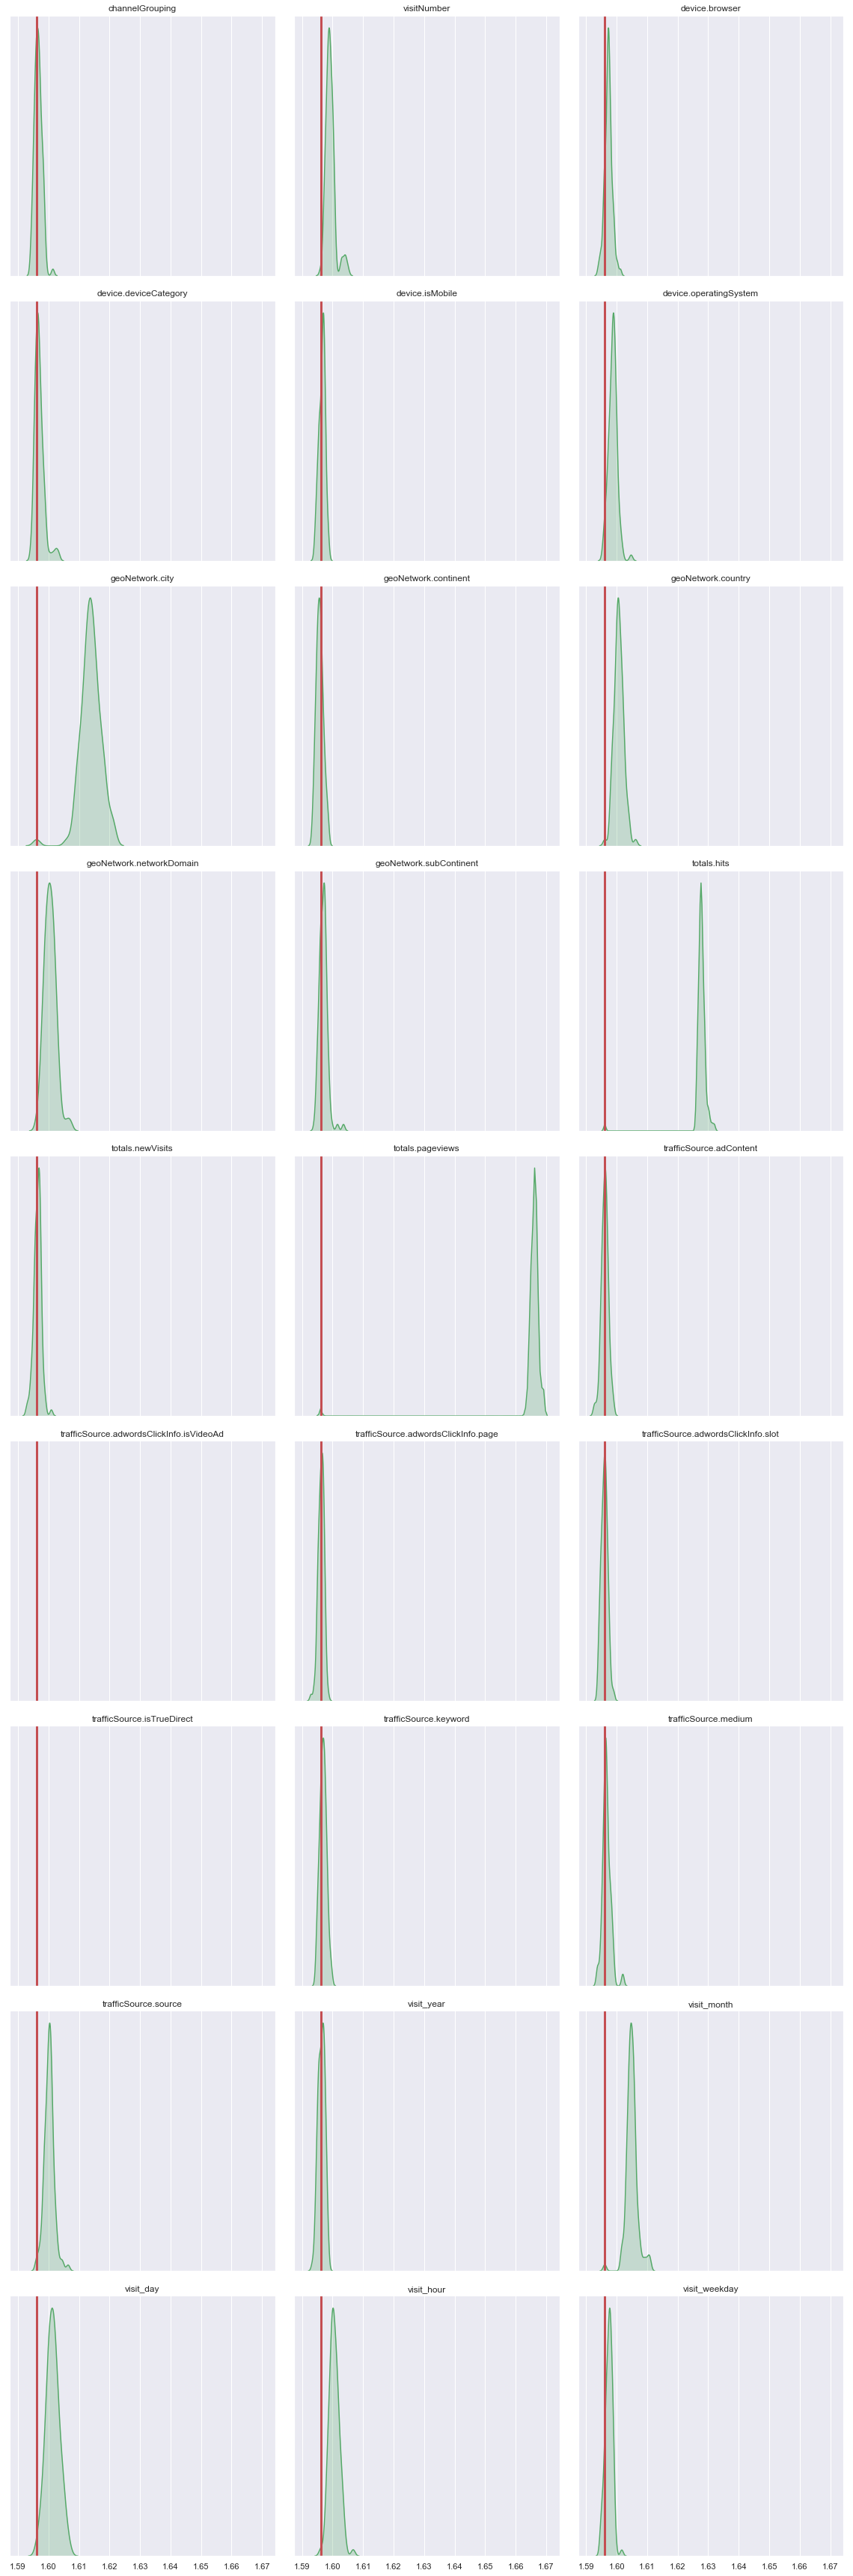

In [189]:
lgbm_permu_f, lgbm_permu_axes = plt.subplots(9, 3, figsize=(16, 48), sharex=True)
for i in range(len(LGBM_permu_dict.keys())):
    k = list(LGBM_permu_dict.keys())[i]
    draw_sub_graph_permutation_test(lgbm_permu_axes[i//3, i-(i//3)*3], LGBM_permu_dict[k]+[RMSE_LGBM], k)
plt.setp(lgbm_permu_axes, yticks=[])
plt.tight_layout()

### Calculate the $p$-value
The quality of LGBM model **is evaluated by RMSE**. The $p$-value of each round permutation test is defined as **the rank of validation RMSE** among all the RMSEs gained from this round of permutation test. The high $p$-value, the lower significance of a feature. Because even random data can gain a better performance on this model.

In [193]:
## plist = {}
for i in range(len(LGBM_permu_dict.keys())):
    k = list(LGBM_permu_dict.keys())[i]
    p = sorted(LGBM_permu_dict[k]+[RMSE_LGBM]).index(RMSE_LGBM)
    plist[k] = p
    print ("Feature name: {}, \t \t p-value: {}".format(k, p))
print ("Overall mean p-value: {}".format(np.mean(list(plist.values()))))

Feature name: channelGrouping, 	 	 p-value: 36
Feature name: visitNumber, 	 	 p-value: 0
Feature name: device.browser, 	 	 p-value: 16
Feature name: device.deviceCategory, 	 	 p-value: 29
Feature name: device.isMobile, 	 	 p-value: 32
Feature name: device.operatingSystem, 	 	 p-value: 2
Feature name: geoNetwork.city, 	 	 p-value: 0
Feature name: geoNetwork.continent, 	 	 p-value: 65
Feature name: geoNetwork.country, 	 	 p-value: 0
Feature name: geoNetwork.networkDomain, 	 	 p-value: 0
Feature name: geoNetwork.subContinent, 	 	 p-value: 28
Feature name: totals.hits, 	 	 p-value: 0
Feature name: totals.newVisits, 	 	 p-value: 38
Feature name: totals.pageviews, 	 	 p-value: 0
Feature name: trafficSource.adContent, 	 	 p-value: 47
Feature name: trafficSource.adwordsClickInfo.isVideoAd, 	 	 p-value: 0
Feature name: trafficSource.adwordsClickInfo.page, 	 	 p-value: 42
Feature name: trafficSource.adwordsClickInfo.slot, 	 	 p-value: 55
Feature name: trafficSource.isTrueDirect, 	 	 p-value: 0
F

Text(0.5, 1.0, 'p-values of permutation tests on each features')

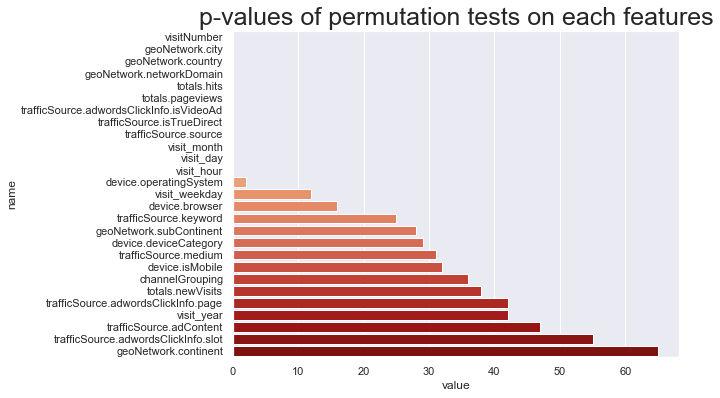

In [206]:
sorted_plist = sorted(plist.items(), key=lambda item: item[1])
sorted_pvalues = pd.DataFrame({'name':[i[0] for i in sorted_plist],
                              'value':[i[1] for i in sorted_plist]})
pg = sns.barplot(x='value', y='name', data=sorted_pvalues, palette=sns.color_palette("OrRd", len(value)))
pg.set(yticklabels = [i[0] for i in sorted_plist])
# pg.set()
pg.set_title("p-values of permutation tests on each features", size=25)

### Findings of permutation test

From the graph we can obtain that over the half of total features significantly affect the LGBM model (with small $p$-values). It is obvious that `visitNumber`, `totals.hits` and `totals.pageviews`, who have the high correlation with transaction revenue will influence the model. What's more, `visit_month`, `visit_day` and `visit_hour` also contribute a lot to the model. Geographic features like `geoNetwork.city` and `geoNetwork.country` are important true. Network information such as `geoNetwork.networkDomain` and `trafficSource.source` is count either. 

For those who not contribute as much as features above, they have larger $p$-values. The largest one, `geoNetwork.continent`, matches my previous visualization on average transaction revenues among continents. There is no such significant difference between continents. As a result, it has a high $p$-value. Similarly, `device.isMobile` also matches my previous visualization plot. To my surprise, `channelGrouping`, which is the method that a customer enters the shop, has little contribution to the selling. So I may conclude that it is the goods of the shop that really count. 